# Lab Instructions

You are working as an analyst for a consulting agency that has been hired to study and improve productivity at a mid-sized company.  Morale is very low and, after speaking with employees, several common complaints kept coming up:

* New employees complained that more tenured employees were lazy and unproductive.
* More tenured employees complained that the newer employees didn't focus and were therefore unproductive.
* Managers were worried that remote workers might be less productive.
* In-person employees found it impossible to focus and be productive when their desk was in the open plan area.
* Many people said they had so much administrative work to do they could only be truly productive if they worked overtime.
* Everyone complained that there were too many meetings.

The consulting agency carefully collected data on a number of factors including number of years at the company, focus (higher is better), productivity (higher is better), department, meetings per week, and desk location can be found in Employee_productivity.csv.

1. Determine which feature - years at the company, hours worked, or focus - has the strongest linear relationship with productivity.  Show a visualization and calculate R-squared for all three relationships to justify your answer.

2. Build on that linear regression model to determine what other featuers also impact productivity. Using both visualzations and R-squared values, build a model that can predicts employee productivity at this company. Evaluate each feature in the dataset.

3. Write a short (a few sentences) summary of how the different factors in the data relate to employee productivity.  What recommendations would you make so that employees can be as productive as possible?



### Setup and Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid", palette="muted")
df = pd.read_csv("Employee_productivity.csv")
display(df.head())
print(df.info())

,HoursWorked,FocusScore,ProductivityScore,Department,YearsAtCompany,TeamMeetingsPerWeek,DeskLocation
0,42.4,6.3,3127.96,Engineering,17,0,Open Plan
1,34.0,7.2,4742.60,HR,8,6,Private Office
2,47.2,5.6,2044.73,Sales,15,3,Remote
3,38.4,9.0,5818.92,HR,5,6,Private Office
4,36.4,2.5,1841.31,Sales,9,6,Remote


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HoursWorked          300 non-null    float64
 1   FocusScore           300 non-null    float64
 2   ProductivityScore    300 non-null    float64
 3   Department           300 non-null    object 
 4   YearsAtCompany       300 non-null    int64  
 5   TeamMeetingsPerWeek  300 non-null    int64  
 6   DeskLocation         300 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 16.5+ KB
None


### 1. Find the Strongest Predictor of Productivity

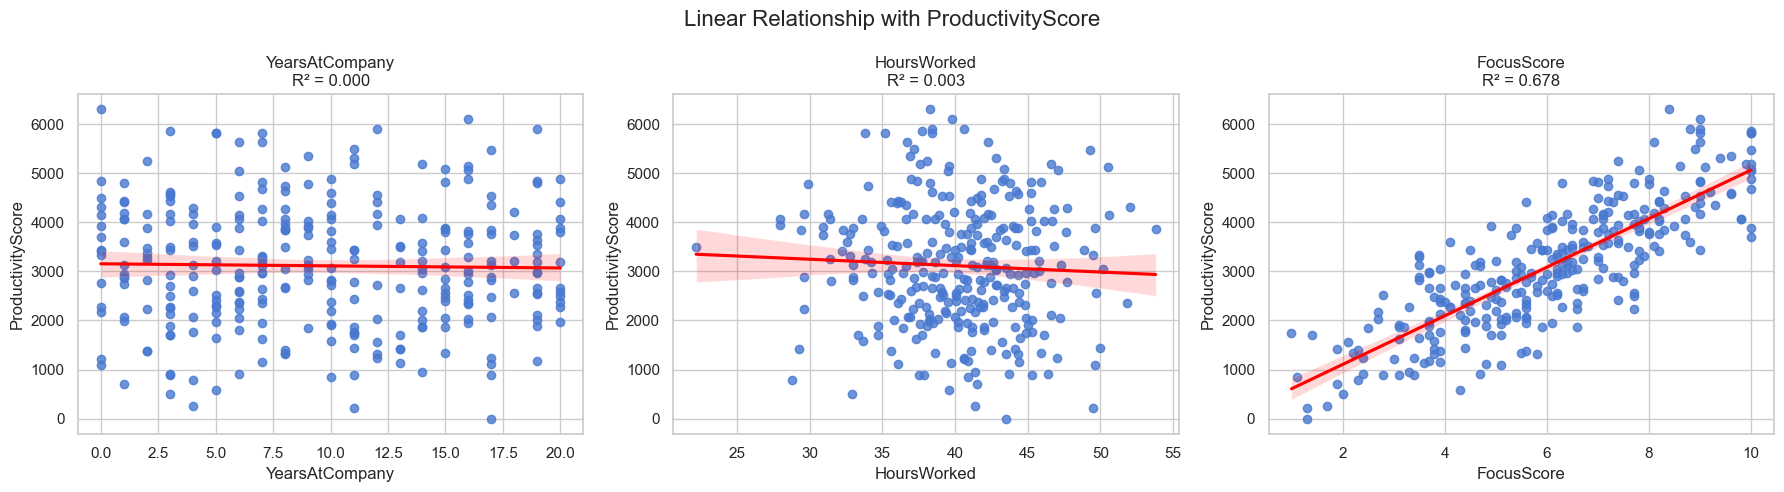

R-squared values for individual features:
YearsAtCompany: 0.0004
HoursWorked: 0.0026
FocusScore: 0.6777


In [5]:
features = ['YearsAtCompany', 'HoursWorked', 'FocusScore']
target = 'ProductivityScore'

r2_results = {}

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Linear Relationship with ProductivityScore', fontsize=16)

for i, feature in enumerate(features):
    X = df[[feature]]
    y = df[target]
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate R-squared
    r2 = r2_score(y, y_pred)
    r2_results[feature] = r2
    
    # Plot
    sns.regplot(x=feature, y=target, data=df, ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f"{feature}\nR² = {r2:.3f}")

plt.tight_layout()
plt.show()

# Print R-squared values
print("R-squared values for individual features:")
for feature, r2 in r2_results.items():
    print(f"{feature}: {r2:.4f}")

### 2. Determine Other Impacts on Productivity


Multiple Linear Regression R-squared on test data: 0.6110


,Feature,Coefficient
7,FocusScore,503.220211
1,Department_Marketing,-261.876976
4,DeskLocation_Remote,-199.283418
2,Department_Sales,-114.683649
3,DeskLocation_Private Office,-74.534491
0,Department_HR,-62.382999
8,TeamMeetingsPerWeek,39.778335
6,HoursWorked,-6.959378
5,YearsAtCompany,4.848285


C:\Users\andre\AppData\Local\Temp\ipykernel_8728\545644499.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')


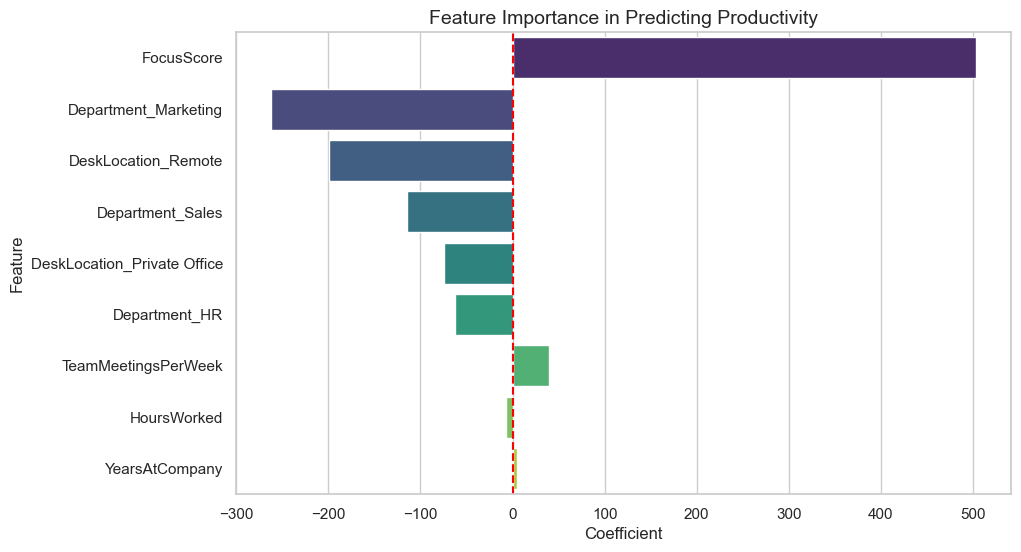

In [6]:
X = df.drop(columns=[target])
y = df[target]

categorical_features = ['Department', 'DeskLocation']
numerical_features = ['YearsAtCompany', 'HoursWorked', 'FocusScore', 'TeamMeetingsPerWeek']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nMultiple Linear Regression R-squared on test data: {r2:.4f}")

encoded_cat_features = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features
coefficients = pipeline.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
display(coef_df)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance in Predicting Productivity', fontsize=14)
plt.axvline(0, color='red', linestyle='--')
plt.show()

### 3. Summary of Key Insights:
1. FocusScore is the most important predictor of productivity (R² ≈ 0.68).
2. Hours worked and years at the company have almost no relationship to productivity.
3. Marketing and Sales teams tend to have lower productivity than Engineering.
4. Remote workers show slightly lower productivity compared to Open Plan workers.
5. Team meetings have a small positive effect on productivity.